In [7]:
import sys
import os
import boto3
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset

import numpy as np
import netCDF4

DEBUG = True

In [8]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    '''Load ROMS NOSOFS dataset'''

    filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')

In [20]:
def dsofs_curr_fcst(COMROT: str='/com/nos'):
    """ Load the currently run OFS forecast on COMROT 
    This is almost the same as dosfs_newest, but will work better
    when running when injected in a workflow.
    It depends on a file being present in COMROT 'current.fcst'
    """
    
    cur_file = f'{COMROT}/current.fcst'
    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
    
    print('fcst: ', fcst)
    
    COMDIR = f'{COMROT}/{fcst}'
    print('COMDIR: ', COMDIR)

    OFS = fcst.split('.')[0]
    fcstdate = fcst.split('.')[-1]
    HH = fcstdate[8:10]
    
    if DEBUG: # Only grab first 0-9 hours. Faster!
        filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    else: # Grab all hours
        filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
        
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')
    

In [32]:
def plot_rho(ds, variable, s3upload=False) -> str:
    
    sample_time = 5
    OFS = ds_ofs.file.split('.')[1]
    
    if variable == 'zeta':
        da = ds[variable].isel(ocean_time=sample_time)
        cmap = cmocean.cm.phase
    if variable == 'temp':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.haline
    if variable == 'oxygen':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.oxy
    if variable == 'Pair':
        da = ds[variable].isel(ocean_time=sample_time)
        cmap = cmocean.cm.diff
      
    fig = plt.figure()
    
    ax = fig.add_axes([0, 0.15, 1, 1], projection=ccrs.PlateCarree())
    im = ax.contourf(
        da.lon_rho, da.lat_rho, da.values,
        transform=ccrs.PlateCarree(),
        cmap=cmap
    )
    
    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);
    
    long_name = da.attrs['long_name']
    start = ds.ocean_time.isel(ocean_time=0)
    sample = da.ocean_time
    end = ds.ocean_time.isel(ocean_time=-1)
    
    start_str = f"Start: {netCDF4.num2date(start, start.units)}"
    sample_str = f"Sample: {netCDF4.num2date(sample, sample.units)}"
    end_str = f"End: {netCDF4.num2date(end, end.units)}"
    now_str = f"Image generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    
    title = f"{str.upper(OFS)} {str.title(da.attrs['long_name'])}"
    ax.set_title(f'{title}\n{start_str}\n{sample_str}\n{end_str}\n{now_str}')
    
    cbar = fig.colorbar(im, ax=ax)

    img = image.imread('docs/rps_small.png')
    logo_axis = fig.add_axes([0.265, 0, 0.2, 0.1])
    logo_axis.imshow(img, interpolation='hanning')
    logo_axis.axis('off')
    
    plt.savefig('docs/roms_test.png', bbox_inches='tight')
    
    return fig.get_size_inches()

In [33]:
 #ds_ofs = dsofs_latest()
ds_ofs = dsofs_curr_fcst()

fcst:  cbofs.2020081800
COMDIR:  /com/nos/cbofs.2020081800
filespec is: /com/nos/cbofs.2020081800/nos.cbofs.fields.f00*.t00z.nc


array([6., 4.])

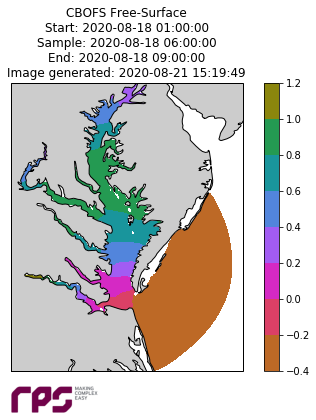

In [34]:
rho_vars = ['temp', 'zeta', 'salt']
var = np.random.choice(rho_vars)

plot_rho(ds_ofs, var)